# WikiAutoencoder - Results
<hr>
### An auto-encoder to help classify article by category on Wikipedia. (Swisscom task)

### The Task:

1. Take N classes of wikipedia articles (laziest way possible)
    * for each class - 1000 articles 
2. Create an autoencoder to compress the articles.
3. Perform classification with typical classifier.
4. Discussion:
    * Compare to a classification on plain text.
    * Compare to PCA

This notebook merely presents the results of this miniproject from a high level. For more details on implementation and fine tuning, a dive into the code is necessary.

### What have I used for this task ?

* Crawling Wikipedia:
    * mediawiki API.
    * `requests` python package.
* Word / Article Representation:
    * stopwords removal from `nltk`.
    * co-occurance probability with a default context size of 6 for each token.
    * article representation through simple sum of co-occurance probability for each token.
* Compression:
    * AutoEncoder:
        * a simple 4 layers NN (implemented with `tensorflow`).
    * PCA:
        * `sklearn` implementation of PCA.
* Classification:
    * LogisticRegression with `sklearn pipeline`.
    * RandomForest with `sklearn pipeline`.
* Visualization:
    * Visualization using `matplotlib`.

### What the data pipeline look like ?

The `WikiDataLoader` class is in charge of gathering the data for the specified number of categories wanted. The raw articles are then processed by a `tokenizer` which transform each articles into a series of tokens. Some token are removed as stopwords and cleared out from this tokenized version. From this tokens we can then compute the co-occurance probability of each of them.

In [15]:
from wiki_dataloader.wiki_dataloader import WikiDataLoader
from word_embedding.tokenizer import Tokenizer

wiki_data_loader = WikiDataLoader(5)

# list storing the different categories of articles that we have.
wiki_data_loader.categories

Category:Physics retrieved from file!
Category:Arts retrieved from file!
Category:Biology retrieved from file!
Category:Electronics retrieved from file!
Category:Earth sciences retrieved from file!


['Category:Physics',
 'Category:Arts',
 'Category:Biology',
 'Category:Electronics',
 'Category:Earth sciences']

In [16]:
# an example of article.
article = next(wiki_data_loader.getFullCorpus())[1]
article

'Physics (from Ancient Greek: φυσική (ἐπιστήμη), translit. physikḗ (epistḗmē), lit. \'knowledge of nature\', from φύσις phýsis "nature") is the natural science that studies matter and its motion and behavior through space and time and that studies the related entities of energy and force. Physics is one of the most fundamental scientific disciplines, and its main goal is to understand how the universe behaves.Physics is one of the oldest academic disciplines and, through its inclusion of astronomy, perhaps the oldest. Over the last two millennia, physics, chemistry, biology, and certain branches of mathematics were a part of natural philosophy, but during the scientific revolution in the 17th century, these natural sciences emerged as unique research endeavors in their own right. Physics intersects with many interdisciplinary areas of research, such as biophysics and quantum chemistry, and the boundaries of physics are not rigidly defined. New ideas in physics often explain the fundame

In [20]:
# the article is then tokenized.
tokenizer = Tokenizer(article)
tokenizer.tokens[0:20]

['physics',
 'from',
 'ancient',
 'greek',
 'translit',
 'physik',
 'epist',
 'lit',
 'knowledge',
 'of',
 'nature',
 'from',
 'ph',
 'sis',
 'nature',
 'is',
 'the',
 'natural',
 'science',
 'that']

In [21]:
# Then we remove stopword and the tokens are ready to generate probabilities of co-occurance.
tokenizer.removeStopWords()
tokenizer.tokens[0:20]

['physics',
 'ancient',
 'greek',
 'translit',
 'physik',
 'epist',
 'lit',
 'knowledge',
 'nature',
 'ph',
 'sis',
 'nature',
 'natural',
 'science',
 'studies',
 'matter',
 'motion',
 'behavior',
 'space',
 'time']

## Classification Results

Results are split into 3 subparts that allow us to compare the results between a compression of the data with autoencoding, a compression with PCA and no compression.

In [1]:
# Generic Script Initial Script.
import pickle
import numpy as np

from wiki_dataloader.wiki_dataloader import WikiDataLoader
from word_embedding.word_embedding import WordEmbedding
from classification.classify import Classify
from classification.visualize import Visualize
%matplotlib inline

# Load 1k articles for 5 wikipedia categories.
wiki_data_loader = WikiDataLoader(5)

# Tokenize, Compute co-occurance, Compact and Convert these articles into a matrices.
word_embedding = WordEmbedding(wiki_data_loader.getFullCorpus)
word_embedding.generateProbArray()

Category:Physics retrieved from file!
Category:Arts retrieved from file!
Category:Biology retrieved from file!
Category:Electronics retrieved from file!
Category:Earth sciences retrieved from file!


### 1. AutoEncoder

The data showed here are reduced to 128 dimensions using a 4 layers auto-encoder neural network. The cost function is a simple sum of squared and activation function are the most classic (sigmoid with weights and bias).

In [2]:
# word_embedding.init_auto_encoder(skip_training=True)
# articles_encoded = word_embedding.create_encoded_article_array()
articles_encoded = pickle.load(
    open('./saved_states/pickles/articles_encoded.pickle', 'rb'))

# Generate a Dataset for classification.
X = np.array([article_encoded['data']
              for article_encoded in articles_encoded])
y = np.array([article_encoded['category']
              for article_encoded in articles_encoded])

# Initialize classifier.
classifier = Classify(X, y)
# Perform Logistic Regression.
y_pred_lr, results_lr = classifier.logistic_regression()
print("=== Logistic Regression ===")
print("Best Parameters from gridSearch:", results_lr['best_params_'])
print("Accuracy obtained on test set: {0:.2f}%".format(results_lr['accuracy'] * 100))
# Perform Random Forest.
y_pred_rf, results_rf = classifier.random_forest()
print("=== Random Forest ===")
print("Best Parameters from gridSearch:", results_rf['best_params_'])
print("Accuracy obtained on test set: {0:.2f}%".format(results_rf['accuracy'] * 100))

=== Logistic Regression ===
Best Parameters from gridSearch: {'C': 1.5}
Accuracy obtained on test set: 0.53%
=== Random Forest ===
Best Parameters from gridSearch: {'max_depth': 8, 'n_estimators': 40}
Accuracy obtained on test set: 0.56%


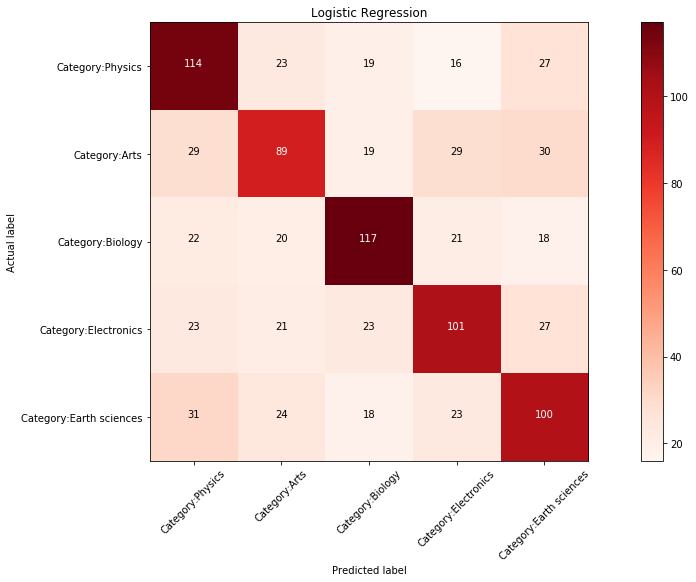

In [4]:
# Visualize the results on a confusion Matrix.
viz = Visualize()
viz.plot_confusion_matrix(classifier.y_test, y_pred_lr,
                          wiki_data_loader.categories, title="Logistic Regression AE")

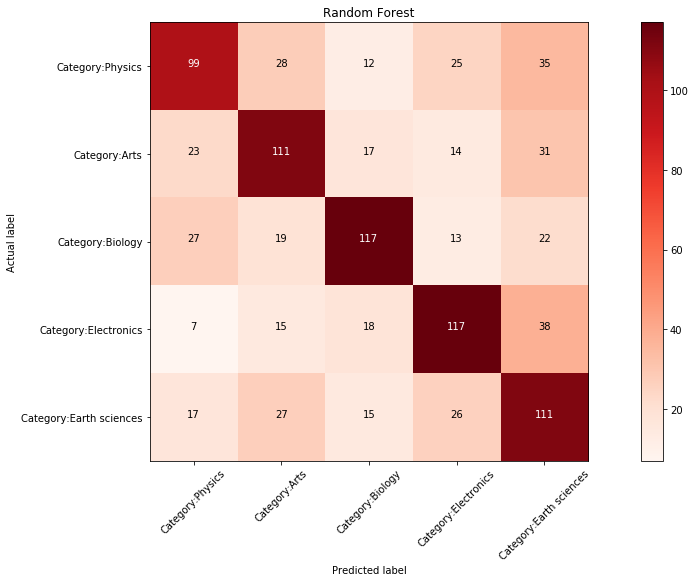

In [5]:
viz.plot_confusion_matrix(classifier.y_test, y_pred_rf,
                          wiki_data_loader.categories, title="Random Forest AE")

### 2. PCA

Data presented in this subsection are reduced using the PCA implementation from sklearn keeping the 128 principal components from our matrix.

In [8]:
# Generate or load PCA from file.
word_embedding.init_PCA()
articles_pca = word_embedding.create_PCA_article_array()

# Generate a Dataset for classification.
X = np.array([article_pca['data']
              for article_pca in articles_pca])
y = np.array([article_pca['category']
              for article_pca in articles_pca])

# Initialize classifier.
classifier = Classify(X, y)
# Perform Logistic Regression.
y_pred_lr, results_lr = classifier.logistic_regression()
print("=== Logistic Regression ===")
print("Best Parameters from gridSearch:", results_lr['best_params_'])
print("Accuracy obtained on test set: {0:.2f}%".format(results_lr['accuracy'] * 100))
# Perform Random Forest.
y_pred_rf, results_rf = classifier.random_forest()
print("=== Random Forest ===")
print("Best Parameters from gridSearch:", results_rf['best_params_'])
print("Accuracy obtained on test set: {0:.2f}%".format(results_rf['accuracy'] * 100))

PCA matrix loaded from file.
=== Logistic Regression ===
Best Parameters from gridSearch: {'C': 1.0}
Accuracy obtained on test set: 0.89%
=== Random Forest ===
Best Parameters from gridSearch: {'max_depth': 10, 'n_estimators': 40}
Accuracy obtained on test set: 0.87%


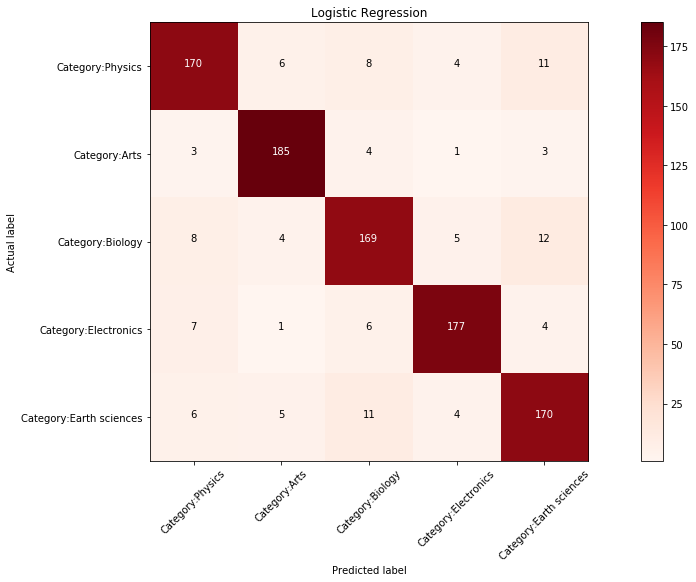

In [9]:
# Visualize the results on a confusion Matrix.
viz = Visualize()
viz.plot_confusion_matrix(classifier.y_test, y_pred_lr,
                          wiki_data_loader.categories, title="Logistic Regression PCA")

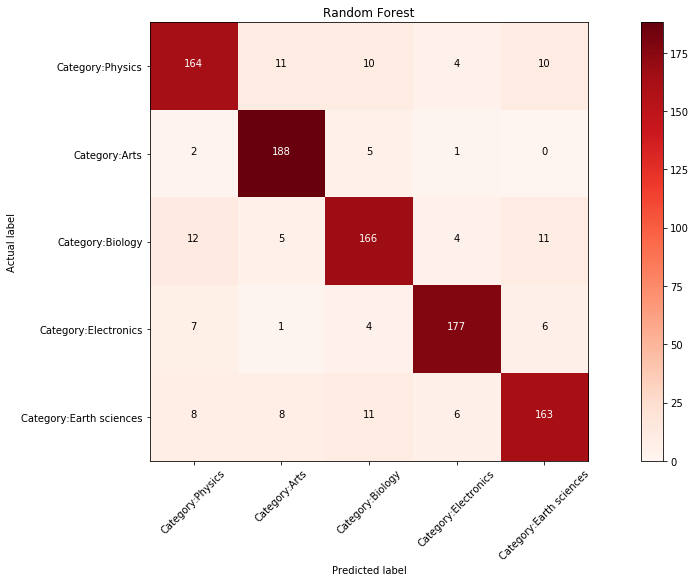

In [10]:
viz.plot_confusion_matrix(classifier.y_test, y_pred_rf,
                          wiki_data_loader.categories, title="Random Forest PCA")

### 3. Uncompressed data

In [ ]:
# Generate or load PCA from file.
articles_raw = word_embedding.create_raw_articles_array()

# Generate a Dataset for classification.
X = np.array([article_raw['data']
              for article_raw in articles_raw])
y = np.array([article_raw['category']
              for article_raw in articles_raw])

# Initialize classifier.
classifier = Classify(X, y)
# Perform Logistic Regression.
y_pred_lr, results_lr = classifier.logistic_regression()
print("=== Logistic Regression ===")
print("Best Parameters from gridSearch:", results_lr['best_params_'])
print("Accuracy obtained on test set: {0:.2f}%".format(results_lr['accuracy'] * 100))
# Perform Random Forest.
y_pred_rf, results_rf = classifier.random_forest()
print("=== Random Forest ===")
print("Best Parameters from gridSearch:", results_rf['best_params_'])
print("Accuracy obtained on test set: {0:.2f}%".format(results_rf['accuracy'] * 100))

In [ ]:
# Visualize the results on a confusion Matrix.
viz = Visualize()
viz.plot_confusion_matrix(classifier.y_test, y_pred_lr,
                          wiki_data_loader.categories, title="Logistic Regression RAW")

In [ ]:
viz.plot_confusion_matrix(classifier.y_test, y_pred_rf,
                          wiki_data_loader.categories, title="Random Forest RAW")